In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data_path
dir_data = './data/TW'
f_app_train = os.path.join(dir_data, '2020data_pchome1.CSV')
app_train = pd.read_csv(f_app_train)

In [2]:
app_train.head()

,member_id,postal_cd,date_cd,prod_id,goods,department,index,prod_Q,price,MSRP
0,15416142,831,day1,QAAD70-A9006TWM5-000,HP Officejet 7110 A3+ 網路高速印表機,3C,列 印,1,"$6,490",NaN
1,4663689,600,day1,QFAXAS-A900A38S1-001,HappyLife_桌上型微波爐架/烤箱置物架 (YV9799),生活,衛浴,1,$599,NaN
2,8097088,815,day1,QFAAJY-A9009W99R-000,dayneeds_輕型 45x45x160cm 四層電鍍波浪收納鐵架,生活,傢俱,1,$927,"$1,359"
3,15317712,708,day1,QAAS33-A900A7SR4-002,任天堂 Switch Joy-Con 四合一鋁合金 手把充電座(兩色可選),3C,電 玩,1,$690,$990
4,15438512,704,day1,CGAACT-A80423382-005,big5,運動戶外,汽百/記錄器,1,"$1,055","$1,600"


In [3]:
# data processing

# 1. replace MSRP NaN value with price value
# 2. tranform type string to float for price and MSRP column
# 3. price and MSRP multiply prod_Q

import math

price_float = []
MSRP_float = []

for i in app_train.index:
    dollars = app_train['price'][i].replace("$","").replace(",","")
    price_float.append(float(dollars) * app_train['prod_Q'][i])
    if type(app_train['MSRP'][i]) == float:
        if math.isnan(app_train['MSRP'][i]):
            dollars = app_train['price'][i].replace("$","").replace(",","")
            MSRP_float.append(float(dollars) * app_train['prod_Q'][i])
    else:
        dollars = app_train['MSRP'][i].replace("$","").replace(",","")
        MSRP_float.append(float(dollars) * app_train['prod_Q'][i])
        
app_train['price_float'] = price_float
app_train['MSRP_float'] = MSRP_float

app_train = app_train.drop(columns=['MSRP', 'price'])
app_train = app_train.rename(columns={"price_float": "price", "MSRP_float": "MSRP"})

app_train.head()

,member_id,postal_cd,date_cd,prod_id,goods,department,index,prod_Q,price,MSRP
0,15416142,831,day1,QAAD70-A9006TWM5-000,HP Officejet 7110 A3+ 網路高速印表機,3C,列 印,1,6490.0,6490.0
1,4663689,600,day1,QFAXAS-A900A38S1-001,HappyLife_桌上型微波爐架/烤箱置物架 (YV9799),生活,衛浴,1,599.0,599.0
2,8097088,815,day1,QFAAJY-A9009W99R-000,dayneeds_輕型 45x45x160cm 四層電鍍波浪收納鐵架,生活,傢俱,1,927.0,1359.0
3,15317712,708,day1,QAAS33-A900A7SR4-002,任天堂 Switch Joy-Con 四合一鋁合金 手把充電座(兩色可選),3C,電 玩,1,690.0,990.0
4,15438512,704,day1,CGAACT-A80423382-005,big5,運動戶外,汽百/記錄器,1,1055.0,1600.0


In [4]:
# calculate DFM data

# Discount = (1 - monetary_total)/MSRP_total
# Frequency = times of purchase
# Monetary = total of price

df = app_train.copy()

df1 = df.groupby('member_id').agg({'date_cd': np.size})
df2 = df.groupby('member_id')['price'].sum()
df3 = df.groupby('member_id')['MSRP'].sum()

df1['Monetary'] = df2
df1['MSRP_Total'] = df3
df3 = df1.rename(columns={'date_cd':'Frequency'})

discount = []

for i in df3.index:
    discount.append(1 - round(df3['Monetary'][i]/df3['MSRP_Total'][i], 3))

df3['Discount'] = discount

df_DFM = pd.DataFrame()
df_DFM['Discount'] = df3['Discount']
df_DFM['Frequency'] = df3['Frequency']
df_DFM['Monetary'] = df3['Monetary']
df_DFM.to_csv ('DFM.csv', index = False, header=True)
df_DFM.head()

,Discount,Frequency,Monetary
member_id,,,
91,0.000,2,2900.0
549,0.091,1,2090.0
1655,0.147,1,2799.0
2241,0.420,2,1025.0
2988,0.539,2,786.0


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\user\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


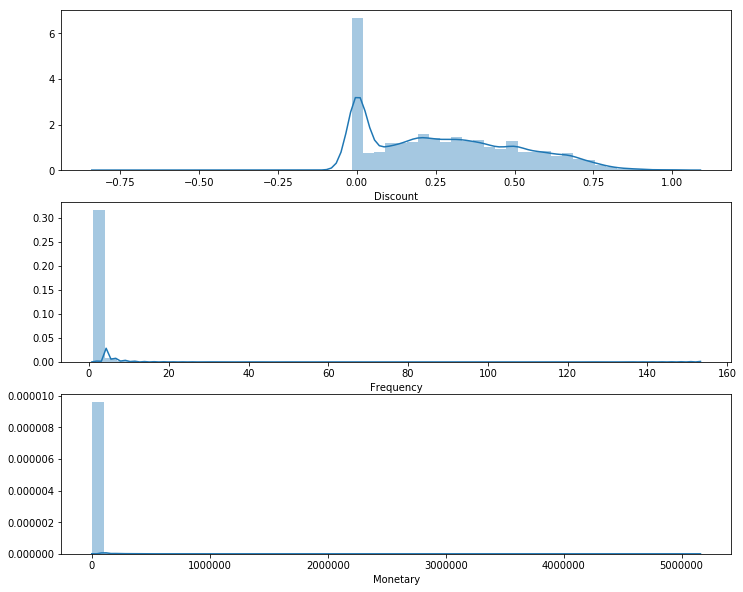

In [5]:
# Plot DFM distributions

plt.figure(figsize=(12,10))
# Plot distribution of D
plt.subplot(3, 1, 1); sns.distplot(df_DFM['Discount'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df_DFM['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df_DFM['Monetary'])
# Show the plot
plt.show()

In [6]:
# Calculate z score

from scipy.stats import zscore

df = df_DFM.apply(zscore)

df_DFM['D_z-score'] = df['Discount']
df_DFM['F_z-score'] = df['Frequency']
df_DFM['M_z-score'] = df['Monetary']
df_DFM.head()

,Discount,Frequency,Monetary,D_z-score,F_z-score,M_z-score
member_id,,,,,,
91,0.000,2,2900.0,-1.190600,0.160412,-0.085772
549,0.091,1,2090.0,-0.798395,-0.299018,-0.107260
1655,0.147,1,2799.0,-0.557038,-0.299018,-0.088452
2241,0.420,2,1025.0,0.619578,0.160412,-0.135511
2988,0.539,2,786.0,1.132462,0.160412,-0.141851


In [7]:
# calculate VS(Value Score)＝ 1.25*ZD + 1* ZF + 1.5* ZM, Weight of DFM

vsScore = []

for i in df_DFM.index:
    vsScore.append(1.25 * df_DFM['D_z-score'][i] + 1 * df_DFM['F_z-score'][i] + 1.5 * df_DFM['M_z-score'][i])

df_DFM['ValueScore'] = vsScore
df_DFM.head()

,Discount,Frequency,Monetary,D_z-score,F_z-score,M_z-score,ValueScore
member_id,,,,,,,
91,0.000,2,2900.0,-1.190600,0.160412,-0.085772,-1.456497
549,0.091,1,2090.0,-0.798395,-0.299018,-0.107260,-1.457901
1655,0.147,1,2799.0,-0.557038,-0.299018,-0.088452,-1.127993
2241,0.420,2,1025.0,0.619578,0.160412,-0.135511,0.731617
2988,0.539,2,786.0,1.132462,0.160412,-0.141851,1.363212


In [8]:
# Rank by Value Score

df_DFM['Rank_ValueScore'] = df_DFM['ValueScore'].rank(method='min', ascending=False)
df_DFM_rank = df_DFM.sort_values(by='ValueScore', ascending=False)
result = df_DFM_rank.reset_index()
result.index += 1
result.head()

,member_id,Discount,Frequency,Monetary,D_z-score,F_z-score,M_z-score,ValueScore,Rank_ValueScore
1,2400440,0.000,2,5160000.0,-1.190600,0.160412,136.719082,203.750785,1.0
2,14255682,0.000,132,1084578.0,-1.190600,59.886310,28.608416,101.310685,2.0
3,17871662,0.016,27,2245276.0,-1.121641,11.646161,59.398807,99.342320,3.0
4,16574617,0.000,153,579500.0,-1.190600,69.534340,15.209971,90.861046,4.0
5,14685763,0.011,35,1868927.0,-1.143191,15.321601,49.415217,88.015438,5.0


In [9]:
# Top 20 % valuable customer

valuable = []
for i in result.index:
    if i <= (len(result.index) * 0.2):
        valuable.append('Valuable Customer')
    else:
        valuable.append('Potential Customer')

result['VS Level'] = valuable

result.to_csv ('DFM_Score.csv', index = False, header=True)

result


,member_id,Discount,Frequency,Monetary,D_z-score,F_z-score,M_z-score,ValueScore,Rank_ValueScore,VS Level
1,2400440,0.000,2,5160000.0,-1.190600,0.160412,136.719082,203.750785,1.0,Valuable Customer
2,14255682,0.000,132,1084578.0,-1.190600,59.886310,28.608416,101.310685,2.0,Valuable Customer
3,17871662,0.016,27,2245276.0,-1.121641,11.646161,59.398807,99.342320,3.0,Valuable Customer
4,16574617,0.000,153,579500.0,-1.190600,69.534340,15.209971,90.861046,4.0,Valuable Customer
5,14685763,0.011,35,1868927.0,-1.143191,15.321601,49.415217,88.015438,5.0,Valuable Customer
6,11521175,0.025,95,735971.0,-1.082851,42.887400,19.360752,70.574964,6.0,Valuable Customer
7,15651146,0.000,65,519752.0,-1.190600,29.104501,13.625007,48.053762,7.0,Valuable Customer
8,17719417,0.000,2,1146000.0,-1.190600,0.160412,30.237787,44.028843,8.0,Valuable Customer
9,14114293,0.287,55,470590.0,0.046355,24.510201,12.320864,43.049440,9.0,Valuable Customer
10,14875891,0.141,42,475780.0,-0.582897,18.537611,12.458541,36.496801,10.0,Valuable Customer
